# Titanic Survivors

- On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
- One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
- Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In [23]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

# big guns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 16, 8

random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)
tf.logging.set_verbosity(tf.logging.ERROR)

Data description can be found here: https://www.kaggle.com/c/titanic/data

In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,None,S


What columns?

In [5]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


Quick & dirty exploration

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.345679,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.028212,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,148,3
top,"Slayter, Miss. Hilda Mary",male,CA. 2343,None,S
freq,1,577,7,687,646


Last row represents frequency of top results found in the column

Pivoting

In [8]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [9]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Visual Exploration

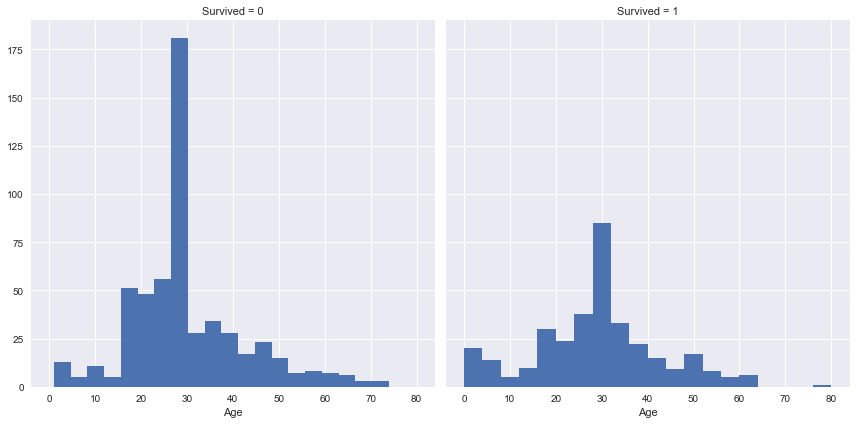

In [10]:
g = sns.FacetGrid(train_df, col='Survived', size=6)
g.map(plt.hist, 'Age', bins=20);

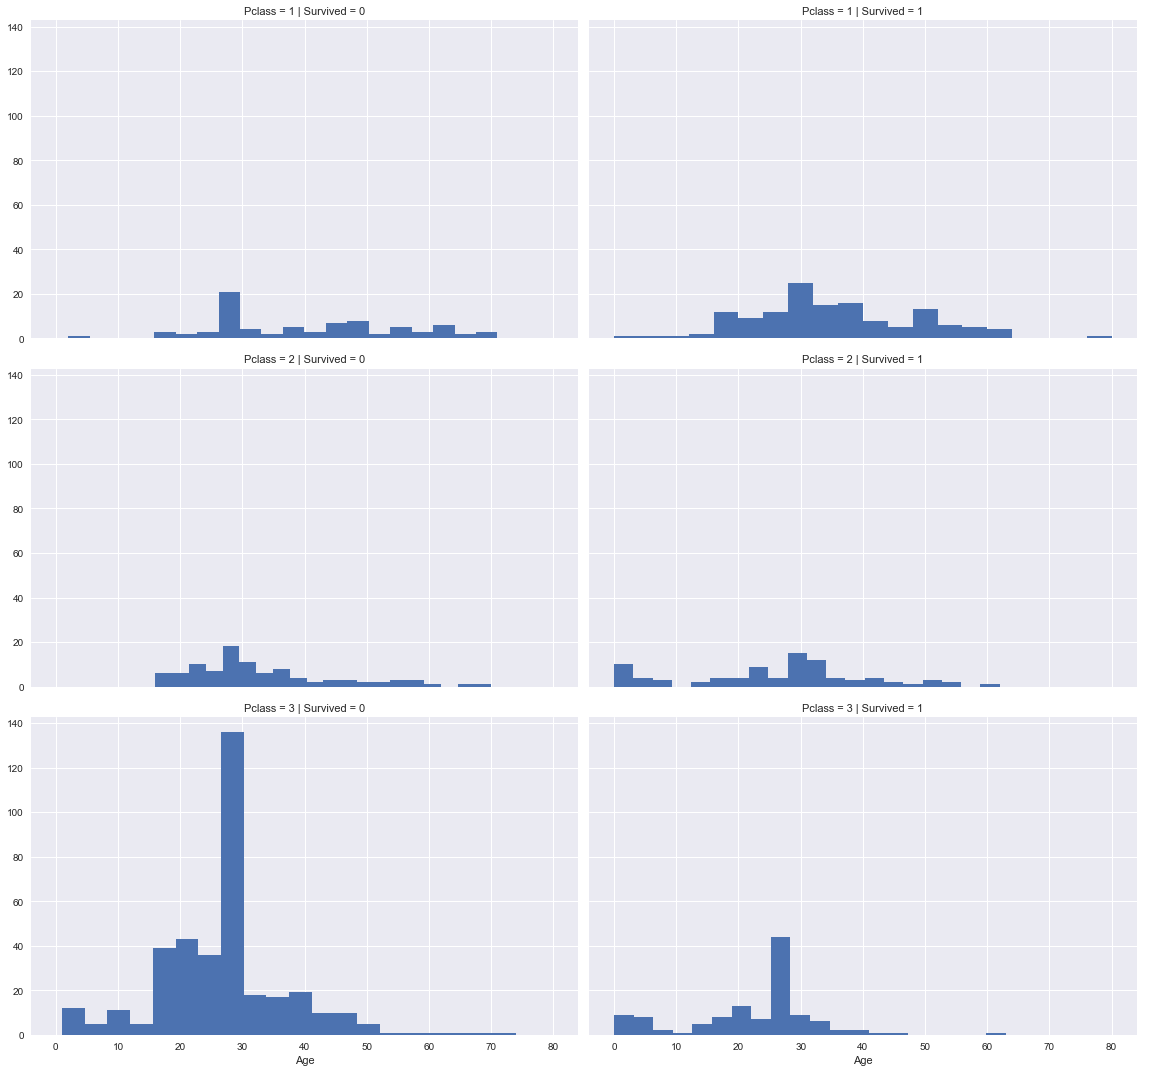

In [11]:
g = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=5, aspect=1.6)
g.map(plt.hist, 'Age', bins=20)
g.add_legend();

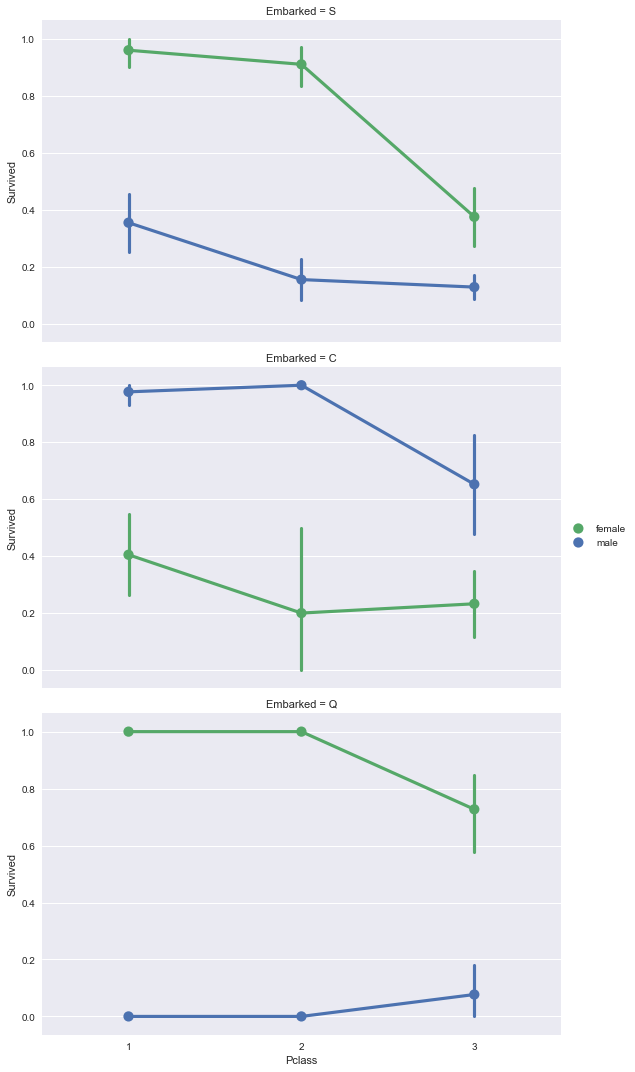

In [12]:
grid = sns.FacetGrid(train_df, row='Embarked', size=5, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend();

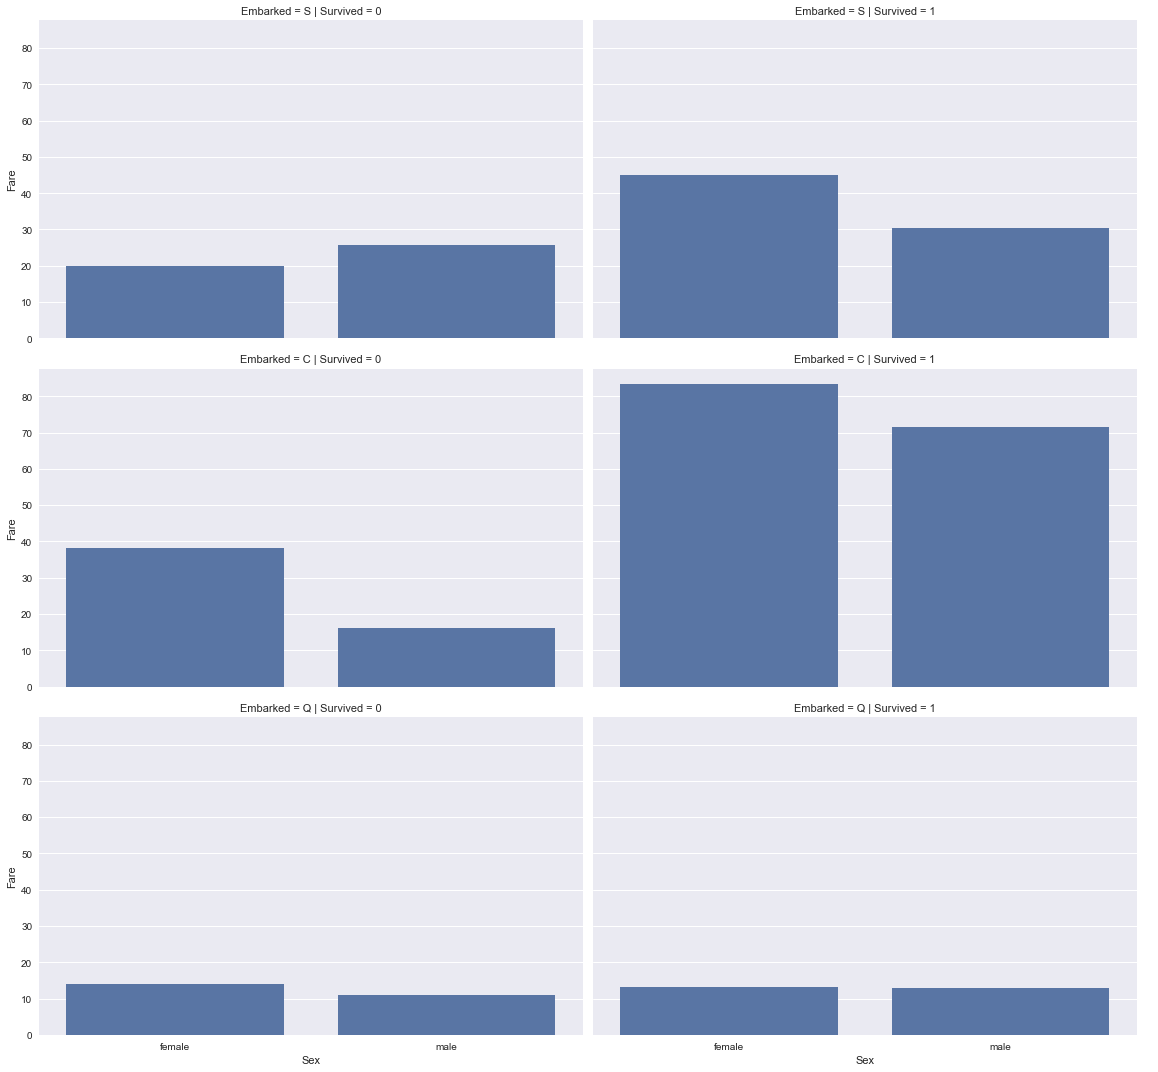

In [13]:
g = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=5, aspect=1.6)
g.map(sns.barplot, 'Sex', 'Fare', ci=None)
g.add_legend();

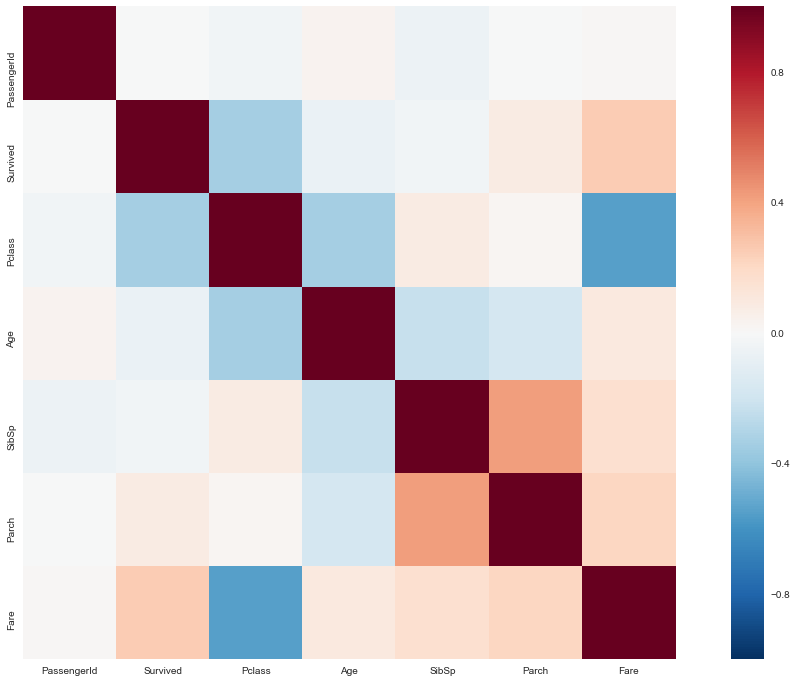

In [14]:
corr_mat = train_df.corr()
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);

## Data hustling

In [15]:
# Impute the missing ages with median age
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median()).astype(int)
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median()).astype(int)

# Fill in missing embarked with S
train_df["Embarked"] = train_df["Embarked"].fillna("S")
test_df["Embarked"] = test_df["Embarked"].fillna("S")

# Fill in missing Cabin with None
train_df["Cabin"] = train_df["Cabin"].fillna("None")
test_df["Cabin"] = test_df["Cabin"].fillna("None")

## Train Test Split

In [16]:
X, y = train_df[['Age','SibSp', 'Fare']], train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=random_state)
X_val, y_val = test_df[['Age','SibSp', 'Fare']], train_df['Survived']

In [17]:
X_train.head()

,Age,SibSp,Fare
331,45,0,28.5000
733,23,0,13.0000
382,32,0,7.9250
704,26,1,7.8542
813,6,4,31.2750


## Modeling

In [18]:
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=3)]

dnn_classifier = tf.contrib.learn.DNNClassifier(hidden_units=[20, 40, 20], 
                                                feature_columns=feature_columns, n_classes=2)

def get_train_inputs():
    x = tf.constant(X_train.values)
    y = tf.constant(y_train.values)

    return x, y

dnn_classifier.fit(input_fn=get_train_inputs, steps=2000);

In [32]:
def get_test_inputs():
    x = tf.constant(X_test.values)
    y = tf.constant(y_test.values)

    return x, y

accuracy_score = dnn_classifier.evaluate(input_fn=get_test_inputs,
                                       steps=1)["accuracy"]
accuracy_score

0.73743016

## Predicting new samples

In [21]:
def new_samples():
    x = tf.constant(X_val.values)
    y = tf.constant(y_val.values)

    return x, y

predictions = list(dnn_classifier.predict(input_fn=new_samples))

In [22]:
print(f"New Samples, Class Predictions: {predictions}\n")

New Samples, Class Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0

## Comparing with other models

In [28]:
from sklearn import tree, ensemble

dt_classifier = tree.DecisionTreeClassifier(max_depth=3) 
dt_classifier.fit(X_train, y_train)

rf_classifier = ensemble.RandomForestClassifier(n_estimators=50)
rf_classifier.fit(X_train, y_train);

In [37]:
print(f"DT Score:  {dt_classifier.score(X_test, y_test)}")
print(f"RF Score:  {rf_classifier.score(X_test, y_test)}")
print(f"DNN Score: {accuracy_score}")

DT Score:  0.6871508379888268
RF Score:  0.7318435754189944
DNN Score: 0.7374301552772522
